In [1]:
%load_ext autoreload

In [2]:
# Import Tensorflow and Keras layers
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras import Model

import math
import numpy as np
import random
import sys

# Utility functions
from utils import idx_load

# Import n-task library
from ntask.atr   import AtrModel, AtrMovingAverage
from ntask.layer import Context
from ntask.model import NTaskModel
from ntask.utils import plot

# TEMP: Remove when model prototypes are done
from collections import defaultdict
import sklearn

if "__should_reload__" in globals():
    print("Reloaded...")
    %autoreload 2
else:
    __should_reload__ = True

In [3]:
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

## Dataset

In [4]:
# Training images
training_images = idx_load("datasets/mnist/train-images.idx3-ubyte")
training_images.shape

(60000, 28, 28)

In [5]:
# Training labels
training_labels = idx_load("datasets/mnist/train-labels.idx1-ubyte")
training_labels.shape

(60000,)

In [6]:
# Testing images
testing_images = idx_load("datasets/mnist/t10k-images.idx3-ubyte")
testing_images.shape

(10000, 28, 28)

In [7]:
# Testing labels
testing_labels = idx_load("datasets/mnist/t10k-labels.idx1-ubyte")
testing_labels.shape

(10000,)

In [8]:
# Normalize the datasets
training_images = training_images.reshape(len(training_images), 28*28) / 255.0
testing_images  = testing_images.reshape(len(testing_images), 28*28) / 255.0

In [9]:
def train_with_validation_plots(model, x_train, y_train, x_test, y_test, epochs, loss_fn, verbose=0):
    
    loss_train = {}
    loss_test = {}
    
    for epoch in range(epochs):
        loss_train[epoch] = loss_fn(y_train, model.predict(x_train))
        loss_test[epoch] = loss_fn(y_test, model.predict(x_test))
        model.fit(x_train, y_train, epochs=1, verbose=verbose)
    
    loss_train[epochs] = loss_fn(y_train, model.predict(x_train))
    loss_test[epochs] = loss_fn(y_test, model.predict(x_test))
    
    plot("Loss Over Epochs", ["Training Loss", "Validation Loss"], loss_train, loss_test)

# ATR Models

## Delayed Switch

This ATR model implements a mechanism to prevent switching on the first *x* epochs at the very beginning of learning or after a switch occurs.

In [10]:
class AtrDelayedSwitch(AtrMovingAverage):
    def __init__(self, *args, switch_delay=1, **kwargs):
        super(AtrDelayedSwitch, self).__init__(*args, **kwargs)
        self.switch_delay = switch_delay
        self.epochs_without_switch = 0
        
    def should_switch(self, context_loss):
        if self.epochs_without_switch >= self.switch_delay:
            if super(AtrDelayedSwitch, self).should_switch(context_loss):
                self.epochs_without_switch = 0
                return True
        self.epochs_without_switch += 1
        return False

## Initial Loss

At the very beginning of learning or immediately after switching, it can be assumed that we are on the correct task. As such, our first few moves can be lossy. This model prevents switching until the noise at the entry of a context settles and starts to descend.

In [11]:
class AtrInitialLoss(AtrMovingAverage):
    
    def __init__(self, *args, **kwargs):
        super(AtrInitialLoss, self).__init__(*args, **kwargs)
        self.initial_atr_value = None
        
    def update_atr_value(self, context_loss, switched):
        is_initial = self.get_value() is None
        super(AtrInitialLoss, self).update_atr_value(context_loss, switched)
        value = self.get_value()
        if switched or is_initial:
            self.initial_atr_value = value
        elif value < (self.initial_atr_value or value):
            self.initial_atr_value = None
            
    def should_switch(self, context_loss):
        if self.initial_atr_value is None:
            return super(AtrInitialLoss, self).should_switch(context_loss)
        return False

In [73]:
class NTaskModelBatchedLearning(NTaskModel):
    
    def _custom_forward_pass(self, x_train, y_train, batch_size):
        """
        This is the training forward pass for an entire epoch

        !!!!! Read through this code as it is a nonstandard training forward pass ( different than model.fit() )
        & NOTE that this does not apply the gradients ie. this does not do a weight update/learn

        """
        
        # Calculate the total number of batches that need to be processed
        num_batches = int(np.ceil(len(x_train) / batch_size))
        
        # Tensorflow 2 style training -- info can be found here: https://www.tensorflow.org/guide/effective_tf2 
        # This is similar to model.fit(), however this is a custom training loop -- ie. it does things differently than model.fit()
        # look at each input and label (there are 4 for the logic gates)
        for start, end in ((s*batch_size, (s + 1)*batch_size) for s in range(num_batches)):
            
            # Slice into batch
            x = x_train[start:end]
            y = y_train[start:end]
            
            with tf.GradientTape() as tape:
                predictions = self(x, training=True) # Forward pass
                loss = self.loss_fn(y, predictions) # Get the loss
            
            # Extract the gradients for the loss of the current sample
            gradients = tape.gradient(loss, self.trainable_variables)
            
            # Apply the gradients
            self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
            
            for context_layer_idx in self.context_layers:
                self.layers[context_layer_idx].add_context_loss(self._calc_context_loss(context_layer_idx, gradients))
#                 print(self.layers[context_layer_idx].context_loss)
                
        
    def fit(self, x_train, y_train, epochs=1, shuffle=True, progress=False, explicit_contexts=None, batch_size=32, validation_data=None, verbose=1):
        
        # Explicit context learning: specify the contexts for ecah of the layers. None=dynamic
        if explicit_contexts is not None:
            if len(explicit_contexts) != len(self.context_layers):
                raise ValueError("Length of explicit contexts does not match the number of context layers")
            for i, idx in enumerate(self.context_layers):
                if explicit_contexts[i] is not None:
                    self.layers[idx].set_hot_context(explicit_contexts[i])
        else:
            explicit_contexts = [None for x in self.context_layers]
        
        # Allocate the memory for plot data
#         self._plot_data_memory_allocate(epochs)
        
        # Determine the default batch size
        if batch_size is None:
            batch_size = len(x_train)
        
        # Shuffle the dataset
        x_train, y_train = sklearn.utils.shuffle(x_train, y_train)
        
        epoch = 0
        while epoch < epochs:
            
            # DEBUG; Display progress
            if progress:
                display_progress(epoch / epochs, title=str([self.layers[i].get_hot_context() for i in self.context_layers]))
            
            # Reset the context loss
            for idx in self.context_layers:
                self.layers[idx].context_loss = 0.0
                
            # Back up the weights in case we switch
            weights = self.get_weights()
            
            # Perform a forward pass
            self._custom_forward_pass(x_train, y_train, batch_size)
            
            # Iterate backwards over the context layers. If a context switch occurs, don't check any other layers
            switched = False
            for i in range(len(self.context_layers) - 1, -1, -1):
                # Fetch the context layer
                context = self.layers[self.context_layers[i]]
                
                # Check if explicit context learning for this layer is set
                dynamic_switch = explicit_contexts[i] is None
                
                # Update the layer and indicate if a task switch occurred
                if context.update_and_switch(dynamic_switch, verbose=verbose) & Context.RESULT_SWITCHED:
                    # A task switch occurred, don't update any other layers/weights
                    switched = True
                    print("Switched on", epoch)
                    break
            
            # If a task switch occurred, we can revert back to the previous weights
            if switched:
                self.set_weights(weights)
                
            else:
                # Add data to plots
                self._add_plot_data()
                
                epoch += 1
                self.total_epochs += 1
                        
                # Reshuffle the dataset
                x_train, y_train = sklearn.utils.shuffle(x_train, y_train)

# Simple MNIST

A quick demonstration showing the learning ability and stability of the raw NTask model

In [60]:
set_seed(5)

### Loss Function

In [61]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

### Optimizer

In [62]:
optimizer = tf.keras.optimizers.Adam(1e-4)

### Model

In [63]:
x_train = training_images[:1000]
y_train = training_labels[:1000]

x_test = testing_images
y_test = testing_labels

In [64]:
inp = Input((28*28))
# x = Flatten()(inp)
x = Dense(128, activation="relu")(inp)
x = Dense(10, activation="softmax")(x)

In [65]:
# model = NTaskModelBatchedLearning(inputs=inp, outputs=x)
model = NTaskModel(inputs=inp, outputs=x)
# model = Model(inputs=inp, outputs=x)

In [66]:
model.compile(
    loss=loss_fn,
    optimizer=optimizer,
    metrics=[tf.keras.metrics.SparseCategoricalCrossentropy()]
)

### Training & Evaluation

#### Epoch-learning Model
SGD(1e-1)

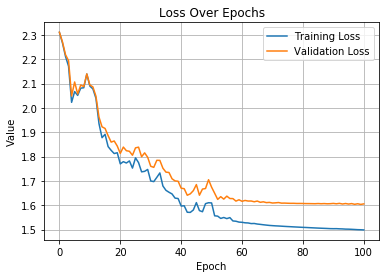

In [44]:
train_with_validation_plots(model, x_train, y_train, x_test, y_test, epochs=100, loss_fn=loss_fn, verbose=0)

#### Batch-learning Model
SGD(1e-1)

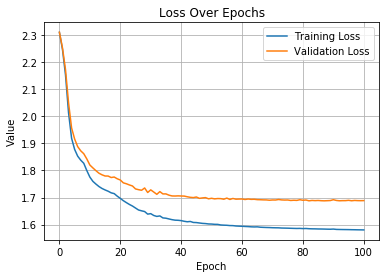

In [52]:
train_with_validation_plots(model, x_train, y_train, x_test, y_test, epochs=100, loss_fn=loss_fn, verbose=0)

#### Epoch-learnig Model

Adam (1e-4)

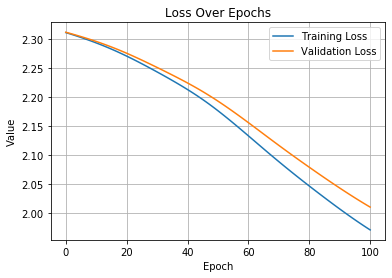

In [67]:
train_with_validation_plots(model, x_train, y_train, x_test, y_test, epochs=100, loss_fn=loss_fn, verbose=0)

#### Batch-learnig Model

Adam (1e-4)

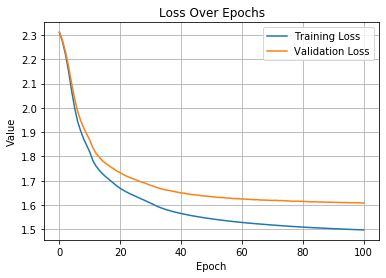

In [18]:
train_with_validation_plots(model, x_train, y_train, x_test, y_test, epochs=100, loss_fn=loss_fn, verbose=0)

In [21]:
result = (np.argmax(model.predict(x_train), axis=1) == y_train).sum()
print(f"{result}/{len(y_train)}; Accuracy: {100*result/len(y_train):.2f}%")

978/1000; Accuracy: 97.80%


In [22]:
result = (np.argmax(model.predict(x_test), axis=1) == y_test).sum()
print(f"{result}/{len(y_test)}; Accuracy: {100*result/len(y_test):.2f}%")

8744/10000; Accuracy: 87.44%


___

## N-task: Predict *x*, 9 - *x*

Task 1: Determine the value in the image. <br>
Task 2: Determine the value in the image and subtract it from 9

In [180]:
set_seed(5)

### Model

In [181]:
x_train = training_images[:1000]
y_train = training_labels[:1000]
y1_train = y_train
y2_train = 9 - y_train

x_test = testing_images
y_test = testing_labels
y1_test = y_test
y2_test = 9 - y_test

In [182]:
inp = Input((28*28,))
# x = Flatten()(inp)
x = Dense(128, activation="relu")(inp)
# x = Context(AtrMovingAverage(2, task_switch_threshold=0))(x)
x = Context(AtrDelayedSwitch(2, task_switch_threshold=2, switch_delay=10))(x)
# x = Context(AtrInitialLoss(2, task_switch_threshold=-0.005))(x)
x = Dense(10, activation="softmax")(x)

In [183]:
model = NTaskModelBatchedLearning(inputs=inp, outputs=x)

In [179]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.SGD(1e-1)
)

### Training and Validation

In [747]:
# for cycle in range(1):
#     for context, y in enumerate([y1_train, y2_train]):
#         print("Context:", context)
#         model.fit(x_train, y, epochs=100, verbose=1, batch_size=32, explicit_contexts=[context])
# #         model.fit(x_train, y, epochs=40, verbose=1, batch_size=8)
#         assert model.layers[2].get_hot_context() == context

In [748]:
model.fit(x_train, y1_train, 40, verbose=1, batch_size=4, explicit_contexts=[0])

In [740]:
model.layers[model.context_layers[0]].atr_model.epochs_without_switch = 40

In [726]:
model.fit(x_train, y2_train, 1, verbose=1, batch_size=32)

Switching... context loss: tf.Tensor(2.330035155702837e-05, shape=(), dtype=float64)
Task switched to: 1
Switched on 0


In [741]:
model.layers[model.context_layers[0]].atr_model.get_value() - 2.330035155702837e-05

<tf.Tensor: shape=(), dtype=float64, numpy=2.944179782474661e-05>

In [622]:
for context, y in enumerate([y1_train, y2_train]):
    model.set_contexts([context])
    result = (np.argmax(model(x_train), axis=1) == y).sum()
    print(f"{result}/{len(y)}; Accuracy: {100*result/len(y):.2f}%")

116/1000; Accuracy: 11.60%
87/1000; Accuracy: 8.70%


In [623]:
for context, y in enumerate([y1_test, y2_test]):
    model.set_contexts([context])
    result = (np.argmax(model(x_test), axis=1) == y).sum()
    print(f"{result}/{len(y)}; Accuracy: {100*result/len(y):.2f}%")

1135/10000; Accuracy: 11.35%
974/10000; Accuracy: 9.74%


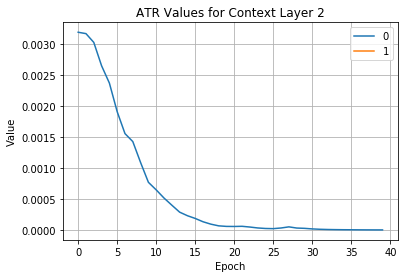

In [749]:
model.plot()

___

## MNIST: n-task

In [74]:
set_seed(5)

### Model

In [75]:
x_train = training_images[:60000]
y_train = training_labels[:60000]

y1_train = np.array([int(i % 2 == 0) for i in y_train]) # Even
y2_train = np.array([int(i % 2 == 1) for i in y_train]) # Odd
y3_train = np.array([int(i % 3 == 0) for i in y_train]) # Divisible by 3

In [76]:
x_test = testing_images
y_test = testing_labels

y1_test = np.array([int(i % 2 == 0) for i in y_test]) # Even
y2_test = np.array([int(i % 2 == 1) for i in y_test]) # Odd
y3_test = np.array([int(i % 3 == 0) for i in y_test]) # Divisible by 3

In [77]:
inp = Input((28*28,))
x = Dense(128, activation="relu")(inp)
# x = Context(AtrMovingAverage(num_tasks=1, task_switch_threshold=-0.02))(x)
x = Dense(1, activation="sigmoid")(x)

In [78]:
model = NTaskModelBatchedLearning(inputs=inp, outputs=x)

In [79]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.SGD(1e-4),
    metrics=[
        tf.keras.metrics.Accuracy()
    ]
)

In [80]:
for cycle in range(1):
    for i, y in enumerate([y1_train]):
        print(i)
#         model.fit(x_train, y, epochs=100, verbose=0, batch_size=32, explicit_contexts=[i])
        model.fit(x_train, y, epochs=10, verbose=1, batch_size=64)

0


In [81]:
for context, y in enumerate([y1_train]):
#     model.set_contexts([context])
    result = (np.round(model(x_train)).astype(int).flatten() == y).sum()
    print(f"{result}/{len(y)}; Accuracy: {100*result/len(y):.2f}%")

30902/60000; Accuracy: 51.50%


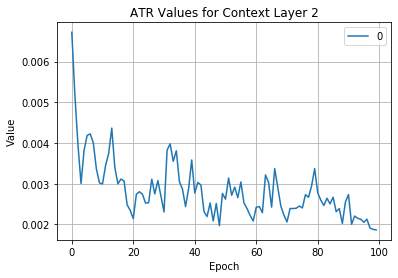

In [966]:
model.plot()

In [83]:
model.evaluate(x_train, y_train)

1875/1875 [==============================] - 1s 565us/step - loss: 0.0000e+00


0.0